# 0.) Load Libraries and Setup Datapaths

In [1]:
# Load libraries
%matplotlib inline
import cv2
import IPython.display as disp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rand
import re
import seaborn as sns
import sys
import tensorflow as tf

from itertools import product
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from os.path import isdir, isfile, join as osjoin
from random import shuffle

# Setup datapaths
base_path = './datasets/IntelImageClassification/'

pred_path = 'seg_pred/seg_pred/'
test_path = 'seg_test/seg_test/'
train_path = 'seg_train/seg_train/'

# Func. to make full paths from base_path
def route(*args):
    full_path = base_path
    for a in args:
        full_path = osjoin(full_path, a)
        
    return full_path

# Make sure paths exist
if isdir(base_path):
    msg = "Couldn't find the dataset path {}. Please check that it is correct."
    
    if not isdir(route(pred_path)):
        print(msg.format(route(pred_path)))
    if not isdir(route(test_path)):
        print(msg.format(route(train_path)))
    if not isdir(route(train_path)):
        print(msg.format(route(train_path)))
else:
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")

In [2]:
# Check for CUDA
CUDA = tf.test.gpu_device_name()

print("CUDA enabled" if CUDA != '' else "CUDA not available")

CUDA enabled


# 1.) Load Images

In [3]:
# Generate labels
labels = []
for folder in listdir(route(train_path)):
    assert(isdir(route(test_path, folder))) # Sanity check
    labels.append(folder)
    
# Func. to eliminate code reuse in loading images
# (adapted from Assignment document)
def load_img(path, x, y):
    for f in sorted([_ for _ in listdir(path) if _.lower().endswith('.jpg')]):
        x += [cv2.resize(cv2.imread(osjoin(path,f)), IMGSIZE)]
        y += [labels.index(label)]
        
    return x, y

In [4]:
%%time
# Load images

IMGSIZE = (128, 128)
x_tr, y_tr, x_ts, y_ts = [], [], [], []
for label in labels:
    # Load training set
    tr_path = route(train_path, label)
    x_tr, y_tr = load_img(tr_path, x_tr, y_tr)
      
    # Load testing set
    ts_path = route(test_path, label)
    x_ts, y_ts = load_img(ts_path, x_ts, y_ts)

Wall time: 58.1 s


In [5]:
# Check the number of channels
channels = len(x_tr[0][0][0])

# Since these are coloured images we expect 3
disp.display_markdown(f"__Number of Channels:__ {channels}", raw=True)

assert(channels == 3)

__Number of Channels:__ 3

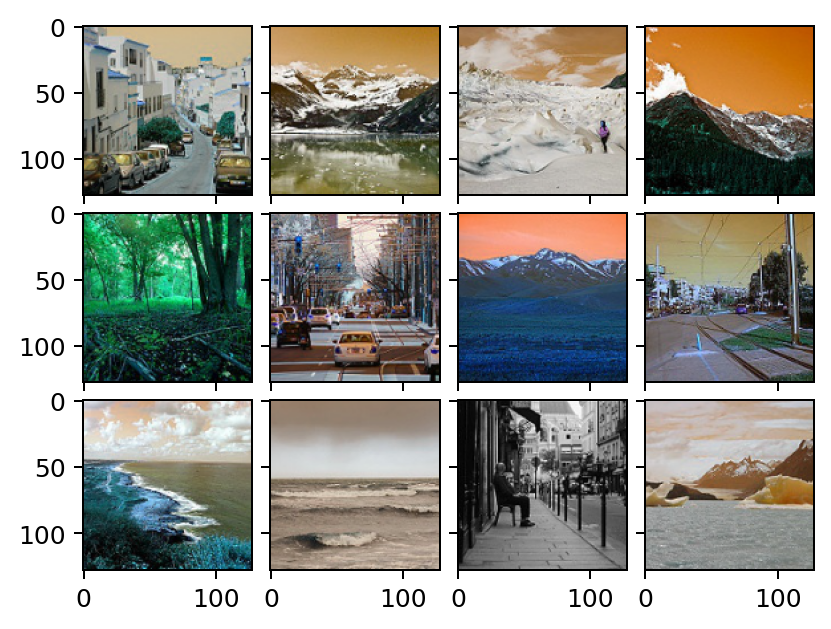

In [6]:
# Display some random images from the set
nrow, ncol = 3, 4
num = nrow * ncol

sample_images = rand.sample(x_tr, num)

fig = plt.figure(dpi=180)
grid = ImageGrid(fig, 111, nrows_ncols=(nrow, ncol), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im)

plt.show()

# 2.) Convert Imageset to Numpy Array and Scale

In [7]:
# Convert
x_tr = np.array(x_tr, dtype=np.float)
y_tr = np.array(y_tr)

x_ts = np.array(x_ts, dtype=np.float)
y_ts = np.array(y_ts)

# Scale
x_tr /= 255.0
x_ts /= 255.0

# Check sanity on shapes
disp.display_markdown(f"__Training Set Shape:__ {x_tr.shape}", raw=True)
disp.display_markdown(f"__Testing Set Shape:__ {x_ts.shape}", raw=True)

disp.display_markdown(f"__Training Targets Shape:__ {y_tr.shape}", raw=True)
disp.display_markdown(f"__Testing Targets Shape:__ {y_ts.shape}", raw=True)

# Check sanity on scale
disp.display_markdown(f"__Training Set Min/Max:__ {x_tr.min()}/{x_tr.max()}", raw=True)
disp.display_markdown(f"__Training Set Min/Max:__ {x_ts.min()}/{x_ts.max()}", raw=True)

__Training Set Shape:__ (14034, 128, 128, 3)

__Testing Set Shape:__ (3000, 128, 128, 3)

__Training Targets Shape:__ (14034,)

__Testing Targets Shape:__ (3000,)

__Training Set Min/Max:__ 0.0/1.0

__Training Set Min/Max:__ 0.0/1.0

# 3.) Create a CNN

In [8]:
EPOCHS = 10

In [9]:
# CNN construction
cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                               data_format='channels_last'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnn.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [10]:
# Build/Compile CNN
tf.random.set_seed(42)

def build_comp(model):
    tf.keras.backend.clear_session()
    model.build(input_shape=(None, 128, 128, 3))

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    
    return model

cnn = build_comp(cnn)

### Train

This cell failed to allocate memory once . . . 

In [11]:
%%time
history = cnn.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/10
439/439 [==============================] - 5s 12ms/step - loss: 0.9990 - accuracy: 0.6246
Epoch 2/10
439/439 [==============================] - 5s 12ms/step - loss: 0.6437 - accuracy: 0.7659
Epoch 3/10
439/439 [==============================] - 5s 12ms/step - loss: 0.4244 - accuracy: 0.8454
Epoch 4/10
439/439 [==============================] - 5s 12ms/step - loss: 0.2270 - accuracy: 0.9213
Epoch 5/10
439/439 [==============================] - 5s 12ms/step - loss: 0.1110 - accuracy: 0.9652
Epoch 6/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0822 - accuracy: 0.9743
Epoch 7/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0623 - accuracy: 0.9813
Epoch 8/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0418 - accuracy: 0.9882
Epoch 9/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0627 - accuracy: 0.9822
Epoch 10/10
439/439 [==============================] - 5s 12ms/step - loss: 0.0427 - accura

### Test

In [12]:
def test(model):
    y_pred = np.argmax(model.predict(x_ts), axis=-1)
    print(f'Accuracy = {sum(y_pred==y_ts)/y_ts.shape[0]:.3f}')

test(cnn)

Accuracy = 0.739


# 4.) Add Dropout/Regularization

Here I ran three models with the final one performing best.
* L1 Regularized: 73% Acc.
* Dropout: 76% Acc.
* L2 Regularization + Dropout + Extra Layers: 83% Accuracy

The final model is only slightly more accurate (~2-3%) with L2 and Dropout as just the same architecture (4 conv. layers) w/o the regularization.

In [13]:
# Up Epochs a bit (50% increase doesn't seem to change results very much)
EPOCHS = 15

### L1 Regularization

In [14]:
# Define Regularizer
regularizer = tf.keras.regularizers.l1(l=0.01)


# Define CNN
cnnl1 = tf.keras.Sequential()

# CNN Layer 1
cnnl1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                                 data_format='channels_last', kernel_regularizer=regularizer))
cnnl1.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

# CNN Layer 2
cnnl1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu',
                                 kernel_regularizer=regularizer))
cnnl1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

cnnl1.add(tf.keras.layers.Flatten())
cnnl1.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnnl1.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [15]:
%%time
# Build/Compile CNN
cnnl1 = build_comp(cnnl1)

# Train
history = cnnl1.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/15
439/439 [==============================] - 5s 11ms/step - loss: 2.5295 - accuracy: 0.5746
Epoch 2/15
439/439 [==============================] - 5s 11ms/step - loss: 1.3693 - accuracy: 0.6844
Epoch 3/15
439/439 [==============================] - 5s 11ms/step - loss: 1.1132 - accuracy: 0.7200
Epoch 4/15
439/439 [==============================] - 5s 11ms/step - loss: 0.9757 - accuracy: 0.7584
Epoch 5/15
439/439 [==============================] - 5s 11ms/step - loss: 0.8723 - accuracy: 0.7858
Epoch 6/15
439/439 [==============================] - 5s 11ms/step - loss: 0.7843 - accuracy: 0.8133
Epoch 7/15
439/439 [==============================] - 5s 11ms/step - loss: 0.6754 - accuracy: 0.8498
Epoch 8/15
439/439 [==============================] - 5s 11ms/step - loss: 0.5881 - accuracy: 0.8764
Epoch 9/15
439/439 [==============================] - 5s 11ms/step - loss: 0.5153 - accuracy: 0.9027
Epoch 10/15
439/439 [==============================] - 5s 11ms/step - loss: 0.4578 - accura

In [16]:
# Test
test(cnnl1)

Accuracy = 0.726


### Dropout

In [17]:
# Define CNN
cnndo = tf.keras.Sequential()

# CNN Layer 1
cnndo.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                                 data_format='channels_last'))
cnndo.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

# CNN Layer 2
cnndo.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu'))
cnndo.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))
cnndo.add(tf.keras.layers.Dropout(0.2))

cnndo.add(tf.keras.layers.Flatten())
cnndo.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnndo.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [18]:
%%time
# Build/Compile CNN
cnndo = build_comp(cnndo)

# Train
history = cnndo.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/15
439/439 [==============================] - 5s 12ms/step - loss: 1.0897 - accuracy: 0.6057
Epoch 2/15
439/439 [==============================] - 5s 11ms/step - loss: 0.6584 - accuracy: 0.7566
Epoch 3/15
439/439 [==============================] - 5s 11ms/step - loss: 0.4865 - accuracy: 0.8198
Epoch 4/15
439/439 [==============================] - 5s 11ms/step - loss: 0.3153 - accuracy: 0.8872
Epoch 5/15
439/439 [==============================] - 5s 11ms/step - loss: 0.2116 - accuracy: 0.9281
Epoch 6/15
439/439 [==============================] - 5s 11ms/step - loss: 0.1230 - accuracy: 0.9592
Epoch 7/15
439/439 [==============================] - 5s 11ms/step - loss: 0.0914 - accuracy: 0.9708
Epoch 8/15
439/439 [==============================] - 5s 11ms/step - loss: 0.0913 - accuracy: 0.9710
Epoch 9/15
439/439 [==============================] - 5s 11ms/step - loss: 0.0614 - accuracy: 0.9823
Epoch 10/15
439/439 [==============================] - 5s 11ms/step - loss: 0.0648 - accura

In [19]:
# Test
test(cnndo)

Accuracy = 0.757


### L2 Regularization + Dropout

In [20]:
# Define Regularizers
reg1 = tf.keras.regularizers.l2(l=0.001)
reg2 = tf.keras.regularizers.l2(l=0.01)

# Define CNN
cnnl2 = tf.keras.Sequential()

# CNN Layer 1
cnnl2.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), name='conv_1', activation='relu',
                                 data_format='channels_last', kernel_regularizer=reg1))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

# CNN Layer 2
cnnl2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), name='conv_2', activation='relu',
                                 kernel_regularizer=reg1))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

# CNN Layer 3
cnnl2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), name='conv_3', activation='relu',
                                 kernel_regularizer=reg2))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_3'))

# CNN Layer 4
cnnl2.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(4,4), name='conv_4', activation='relu',
                                 kernel_regularizer=reg2))
cnnl2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_4'))
cnnl2.add(tf.keras.layers.Dropout(0.2))

# Flatten and Fully Connect
cnnl2.add(tf.keras.layers.Flatten())
cnnl2.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))
cnnl2.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [21]:
%%time
# Build/Compile CNN
cnnl2 = build_comp(cnnl2)

# Train
history = cnnl2.fit(x_tr, y_tr, epochs=EPOCHS, shuffle=True)

Epoch 1/15
439/439 [==============================] - 4s 10ms/step - loss: 1.2777 - accuracy: 0.5418
Epoch 2/15
439/439 [==============================] - 4s 9ms/step - loss: 0.9529 - accuracy: 0.6565
Epoch 3/15
439/439 [==============================] - 4s 9ms/step - loss: 0.8477 - accuracy: 0.7101
Epoch 4/15
439/439 [==============================] - 4s 9ms/step - loss: 0.7675 - accuracy: 0.7443
Epoch 5/15
439/439 [==============================] - 4s 9ms/step - loss: 0.7142 - accuracy: 0.7677
Epoch 6/15
439/439 [==============================] - 4s 9ms/step - loss: 0.6758 - accuracy: 0.7820
Epoch 7/15
439/439 [==============================] - 4s 9ms/step - loss: 0.6649 - accuracy: 0.7838
Epoch 8/15
439/439 [==============================] - 4s 9ms/step - loss: 0.6179 - accuracy: 0.8051
Epoch 9/15
439/439 [==============================] - 4s 9ms/step - loss: 0.5961 - accuracy: 0.8133
Epoch 10/15
439/439 [==============================] - 4s 9ms/step - loss: 0.5795 - accuracy: 0.822

In [22]:
# Test
test(cnnl2)

Accuracy = 0.825
